In [4]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as T

import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets
from torch.utils.data import DataLoader, Dataset
from pathlib import Path

import numpy as np

# device = "cuda"
device= "mps"

In [5]:
%matplotlib inline

In [6]:
!pip install gdown
!pip install scipy

# We are going to use the Calthech101 dataset

In [7]:
input_transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
])

dataset = torchvision.datasets.Caltech101(root=Path.cwd(), 
                                          target_type = 'category', 
                                          transform = input_transform, 
                                          target_transform = None, 
                                          download= True)

dataloader = DataLoader(dataset, batch_size=32)



Downloading...
From (original): https://drive.google.com/uc?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp
From (redirected): https://drive.usercontent.google.com/download?id=137RyRjvTBkBiIfeYBNZBtViDHQ6_Ewsp&confirm=t&uuid=e106d1f9-0a18-41fc-9802-32e1fb773fad
To: /Users/pierr/Library/CloudStorage/OneDrive-Personnel/Documents/GitHub/computer-vision-learning/caltech101/101_ObjectCategories.tar.gz
100%|██████████| 132M/132M [00:24<00:00, 5.28MB/s] 


Extracting /Users/pierr/Library/CloudStorage/OneDrive-Personnel/Documents/GitHub/computer-vision-learning/caltech101/101_ObjectCategories.tar.gz to /Users/pierr/Library/CloudStorage/OneDrive-Personnel/Documents/GitHub/computer-vision-learning/caltech101


Downloading...
From: https://drive.google.com/uc?id=175kQy3UsZ0wUEHZjqkUDdNVssr7bgh_m
To: /Users/pierr/Library/CloudStorage/OneDrive-Personnel/Documents/GitHub/computer-vision-learning/caltech101/Annotations.tar
100%|██████████| 14.0M/14.0M [00:02<00:00, 5.49MB/s]


Extracting /Users/pierr/Library/CloudStorage/OneDrive-Personnel/Documents/GitHub/computer-vision-learning/caltech101/Annotations.tar to /Users/pierr/Library/CloudStorage/OneDrive-Personnel/Documents/GitHub/computer-vision-learning/caltech101


the dataset includes 8677 samples


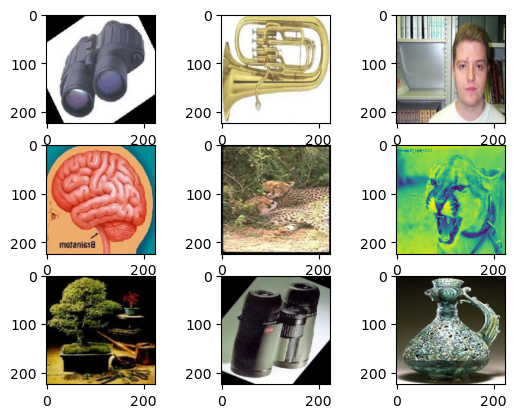

In [8]:
indexes = np.random.randint(0, len(dataset), (3,3))

fig, axes = plt.subplots(3,3)

for i in range(3):
    for j in range(3):
        img, _ = dataset[indexes[i,j]]
        axes[i,j].imshow(img.permute(1,2,0))

# Dataset presentation : 
print(f"the dataset includes {len(dataset)} samples")

# Model creation

In [94]:
D = 768
N = 100

z = torch.randn((N, D_h))

In [10]:
z.shape

torch.Size([100, 768])

In [121]:
class SelfAttention(nn.Module):
    def __init__(self, D_input, D_h):
        super().__init__()
        self.D_h = D_h
        self.D_input=D_input

        self.q_mat = nn.Linear(in_features=self.D_input, out_features=self.D_h, bias=None)
        self.k_mat = nn.Linear(in_features=self.D_input, out_features=self.D_h, bias=None)
        self.v_mat = nn.Linear(in_features=self.D_input, out_features=self.D_h, bias=None)
    
    def forward(self, z):
        q, k, v = self.q_mat(z), self.k_mat(z), self.v_mat(z)
        A = torch.softmax(torch.matmul(q, torch.transpose(k, 1, 0)) / torch.sqrt(torch.tensor(self.D_h)), axis=1)
        return torch.matmul(A, v)
        

# class MSA(nn.Module):
#     def __init__(self, embedding_dim, num_heads):
#         super().__init__()
#         self.k = num_heads
#         self.D_input = embedding_dim
#         self.D_h = embedding_dim//num_heads

#         self.attentions = [SelfAttention(self.D_h, self.D_h) for i in range(self.k)]
#         self.unification_matrix = nn.Linear(self.D_input, self.D_input, bias=None)
    
#     def forward(self, z):
#         vectors = torch.split(z, split_size_or_sections=self.D_h, dim=1)

#         for i in range(self.k):
#             vectors[i] = self.attentions[i](vectors[i])

#         MSA = torch.cat(vectors, dim=1)
#         return self.unification_matrix(MSA)
    

class MSA(nn.Module):
    def __init__(self, embedding_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embedding_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.query = nn.Linear(embedding_dim, embedding_dim)
        self.key = nn.Linear(embedding_dim, embedding_dim)
        self.value = nn.Linear(embedding_dim, embedding_dim)
        self.fc_out = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x):
        N, seq_length, embedding_dim = x.shape

        # Split the embedding into self.num_heads different pieces
        queries = self.query(x).view(N, seq_length, self.num_heads, self.head_dim)
        keys = self.key(x).view(N, seq_length, self.num_heads, self.head_dim)
        values = self.value(x).view(N, seq_length, self.num_heads, self.head_dim)

        # Transpose to get dimensions (N, num_heads, seq_length, head_dim)
        queries = queries.transpose(1, 2)
        keys = keys.transpose(1, 2)
        values = values.transpose(1, 2)

        # Calculate the attention scores
        scores = torch.matmul(queries, keys.transpose(-2, -1)) * self.scale
        attention = torch.softmax(scores, dim=-1)

        # Get the weighted values
        out = torch.matmul(attention, values)

        # Reshape to (N, seq_length, embedding_dim)
        out = out.transpose(1, 2).contiguous().view(N, seq_length, embedding_dim)

        # Apply the final linear layer (unification layer)
        out = self.fc_out(out)
        return out

class MLP(nn.Module):
    def __init__(self, embedding_dim, mlp_size, dropout=0.1):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.mlp_size = mlp_size
        
        self.block = nn.Sequential(nn.LayerNorm(normalized_shape=self.embedding_dim),
                        nn.Linear(in_features=embedding_dim, out_features=mlp_size),
                        nn.GELU(),
                        nn.Dropout(dropout),
                        nn.Linear(in_features=mlp_size, out_features=embedding_dim),
                        nn.Dropout(dropout))

    def forward(self, z):
        return self.block(z)



In [118]:
sa = SelfAttention(D, D)
print(sa(z).shape)
print(f"Q: {sa.q_mat._parameters['weight'].shape}, K: {sa.k_mat._parameters['weight'].shape}, V: {sa.q_mat._parameters['weight'].shape}")

summary(sa)

# msa = MSA(embedding_dim=768, num_heads=16)
# output_attention = msa.forward(z)
# print(output_attention.shape)

torch.Size([100, 768])
Q: torch.Size([768, 768]), K: torch.Size([768, 768]), V: torch.Size([768, 768])


Layer (type:depth-idx)                   Param #
SelfAttention                            --
├─Linear: 1-1                            589,824
├─Linear: 1-2                            589,824
├─Linear: 1-3                            589,824
Total params: 1,769,472
Trainable params: 1,769,472
Non-trainable params: 0

In [123]:
msa = MSA(embedding_dim=768, num_heads=16)

summary(msa)

Layer (type:depth-idx)                   Param #
MSA                                      --
├─Linear: 1-1                            590,592
├─Linear: 1-2                            590,592
├─Linear: 1-3                            590,592
├─Linear: 1-4                            590,592
Total params: 2,362,368
Trainable params: 2,362,368
Non-trainable params: 0

In [124]:
msa

MSA(
  (query): Linear(in_features=768, out_features=768, bias=True)
  (key): Linear(in_features=768, out_features=768, bias=True)
  (value): Linear(in_features=768, out_features=768, bias=True)
  (fc_out): Linear(in_features=768, out_features=768, bias=True)
)

In [125]:
for x in torch.split(z, split_size_or_sections=D_h, dim=1):
    print(x.shape)

torch.Size([100, 768])


In [126]:
class Encoder(nn.Module):
    def __init__(self,
                embedding_dim:int=768,
                num_heads:int=12,
                mlp_size:int=3072, 
                mlp_dropout:float=0.1, 
                attn_dropout:float=0):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.mlp_size = mlp_size
        self.mlp_dropout = mlp_dropout
        self.attn_dropout = attn_dropout

        self.norm = nn.LayerNorm(normalized_shape=self.embedding_dim)

        self.MSA = MSA(self.embedding_dim, self.num_heads)
        self.MLP = MLP(embedding_dim=self.embedding_dim, mlp_size=self.mlp_size, dropout=self.mlp_dropout)

    
    def forward(self, x):
        att_x = self.MSA(self.norm(x)) + x

        mlp_x = self.MLP(self.norm(att_x)) + x 
        return mlp_x



class PatchEmbedder(nn.Module):

    def __init__(self, patch_size: int, embedding_dim:int = 768, batch_size=32, patch_num=196):
        super().__init__()

        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.patch_num = patch_num

        self.conv = nn.Conv2d(in_channels=3, out_channels=embedding_dim, 
                              kernel_size=(patch_size, patch_size), stride=patch_size, padding=0)
                            # donne en gros le meme resultat que couper en petits patches, flatten et passer dans une linear layer
        self.flat = nn.Flatten(start_dim=2, end_dim=3)

        # ADD [CLASS] TOKEN
        # self.class_embedding= nn.Parameter(torch.rand((1, patch_size**2, embedding_dim)), requires_grad=True)
        self.class_embedding= nn.Parameter(torch.ones((batch_size, 1, embedding_dim)), requires_grad=True)

        # ADD POSITION EMBEDDING
        self.pos_embedding= nn.Parameter(torch.ones((1, patch_num+1 , embedding_dim)), requires_grad=True)
        # self.pos_embedding= nn.Parameter(torch.rand((1, patch_num+1 , embedding_dim)), requires_grad=True)
        # Add the position embedding to the patch and class token embedding

    def forward(self, x):
        y = self.flat(self.conv(x))
        y = y.permute(0, 2, 1)
        
        return torch.cat((self.class_embedding, y),dim=1) + self.pos_embedding


class TransformerEncoder(nn.Module):
    def __init__(self, 
                 patch_size: int=16,
                 embedding_dim:int=768,
                 num_heads:int=12,
                 mlp_size:int=3072, 
                 mlp_dropout:float=0.1, 
                 attn_dropout:float=0, 
                 batch_size=32, 
                 patch_num=196):
        
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.num_heads = num_heads
        self.mlp_size = mlp_size
        self.mlp_dropout = mlp_dropout
        self.attn_dropout = attn_dropout
        
        self.embedder = PatchEmbedder(patch_size=self.patch_size, embedding_dim=self.embedding_dim, patch_num=patch_num, batch_size=batch_size)
        self.encoder = Encoder(self.embedding_dim,
                                self.num_heads,
                                self.mlp_size,
                                self.mlp_dropout,
                                self.attn_dropout)
    
    def forward(x):
        pass
        
        
        


tensor([[[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.7592, 0.8037, 1.0986,  ..., 1.2645, 0.8234, 0.8584],
         [0.7334, 0.5653, 1.2464,  ..., 1.5250, 0.9044, 0.7557],
         ...,
         [0.8065, 0.7712, 1.0774,  ..., 1.2954, 0.9569, 0.9016],
         [0.8333, 0.7735, 1.0776,  ..., 1.3021, 0.9702, 0.9058],
         [0.8349, 0.7980, 1.0420,  ..., 1.2783, 0.9649, 0.9084]],

        [[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.8533, 0.7764, 1.0750,  ..., 1.3502, 1.0050, 0.9954],
         [0.8116, 0.7804, 1.1484,  ..., 1.1966, 0.9395, 1.0099],
         ...,
         [0.7097, 0.6588, 1.2695,  ..., 1.5291, 0.7463, 0.7898],
         [0.6498, 0.6745, 1.1620,  ..., 1.5047, 0.8699, 0.8097],
         [0.7521, 0.6213, 1.0746,  ..., 1.4413, 0.9425, 0.7928]],

        [[2.0000, 2.0000, 2.0000,  ..., 2.0000, 2.0000, 2.0000],
         [0.5747, 0.3605, 1.4810,  ..., 1.9666, 0.7069, 0.6609],
         [0.4496, 0.1615, 1.3858,  ..., 2.0524, 0.7504, 0.

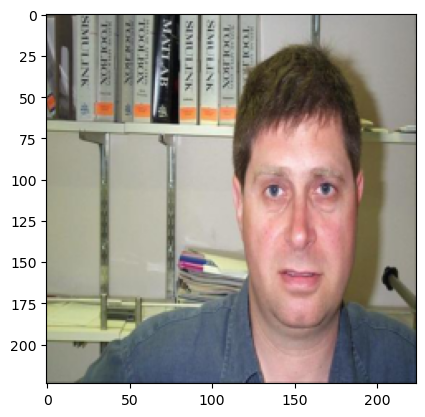

In [127]:
plt.imshow(next(iter(dataloader))[0][0].permute(1, 2, 0))

embedder = PatchEmbedder(patch_size=16, embedding_dim=768)
embedder(next(iter(dataloader))[0])

In [128]:
def train(model, train_loader, test_loader, criterion, optimizer, n_epochs):
    # Dictionary to store losses
    losses = {'train_loss': [], 'test_loss': []}
    
    for epoch in range(n_epochs):
        model.train()  # Set the model to training mode
        running_train_loss = 0.0
        
        # Training loop
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()  # Zero the parameter gradients
            
            outputs = model(inputs)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            loss.backward()  # Backward pass
            optimizer.step()  # Optimize the model parameters
            
            running_train_loss += loss.item() * inputs.size(0)  # Accumulate loss
        
        epoch_train_loss = running_train_loss / len(train_loader.dataset)
        losses['train_loss'].append(epoch_train_loss)
        
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        running_test_loss = 0.0
        
        with torch.no_grad():  # Disable gradient computation
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                
                outputs = model(inputs)  # Forward pass
                loss = criterion(outputs, labels)  # Compute loss
                
                running_test_loss += loss.item() * inputs.size(0)  # Accumulate loss
        
        epoch_test_loss = running_test_loss / len(test_loader.dataset)
        losses['test_loss'].append(epoch_test_loss)
        
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")
    
    return losses

# Example usage:
# model = MyModel().to(device)
# criterion = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
# n_epochs = 10
# losses = train(model, train_loader, test_loader, criterion, optimizer, n_epochs)

In [129]:
encod= Encoder()

summary(encod)

Layer (type:depth-idx)                   Param #
Encoder                                  --
├─LayerNorm: 1-1                         1,536
├─MSA: 1-2                               --
│    └─Linear: 2-1                       590,592
│    └─Linear: 2-2                       590,592
│    └─Linear: 2-3                       590,592
│    └─Linear: 2-4                       590,592
├─MLP: 1-3                               --
│    └─Sequential: 2-5                   --
│    │    └─LayerNorm: 3-1               1,536
│    │    └─Linear: 3-2                  2,362,368
│    │    └─GELU: 3-3                    --
│    │    └─Dropout: 3-4                 --
│    │    └─Linear: 3-5                  2,360,064
│    │    └─Dropout: 3-6                 --
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0

In [73]:
from torchinfo import summary

In [ ]:
msa